In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection
import keras

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

# The Function used to plot the original image and the predicted image 
def Plot_Img(n,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
    
import random
# The Function used to remove the middle square of the image
def Img_incomp_rand_patches(imgs_mod,imgs,cond,w=12):
    n = imgs.shape[0]
    patches = []
    for i in range(n):
        start = random.randint(0,31-w)
        end = start+w
        imgs_mod[i][start:end,start:end,:] = 0
        cond[i][start:end,start:end,:] = 0
        patches.append(imgs[i][start:end,start:end,:])
    return imgs_mod,cond,patches 

h_dim = 1024
batch_size = 50
height = 32
width = 32
channels = 3

Using TensorFlow backend.


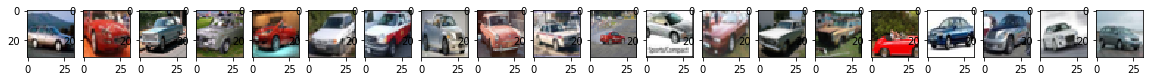

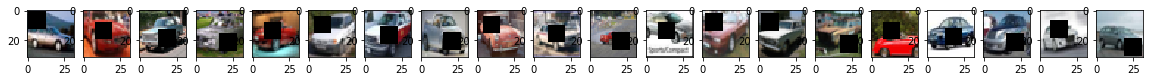

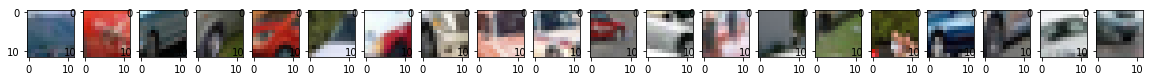

In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]
x_test = x_test[y_test.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(x_tra,y_tra),(x_te,y_te) = keras.datasets.cifar10.load_data()
x_tra = x_tra[y_tra.flatten() == 1]
x_te = x_te[y_te.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_tra = x_tra.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.

cond_train = np.ones((x_train.shape[0],32,32,1))
cond_test = np.ones((x_test.shape[0],32,32,1))

# Modfied training and testing imgs
x_train,cond_train,x_train_patches = Img_incomp_rand_patches(x_train,x_tra,cond_train)
x_test,cond_test,x_test_patches = Img_incomp_rand_patches(x_test,x_te,cond_test)

x_train_patches = np.array(x_train_patches)
x_test_patches = np.array(x_test_patches)
# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
Plot_Img(20,x_train_patches,20,10)
plt.show()

In [0]:
def full_csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def full_cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.square(x-decode_z),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + full_cvae_log_var - K.square(full_cvae_mu) - K.exp(full_cvae_log_var),axis=-1)
    return xent_loss + kl_loss

In [4]:
# Construct the CVAE model
full_X = layers.Input(batch_shape=(batch_size,height,width,channels))
full_cond = layers.Input(batch_shape=(batch_size,height,width,1))
full_cvae_Input = layers.concatenate([full_X,full_cond], axis=-1)
full_cvae_l1 = layers.Conv2D(32,(3,3),activation='relu',strides=2,padding='same')(full_cvae_Input)
full_cvae_l1 = layers.BatchNormalization()(full_cvae_l1)
full_cvae_l2 = layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(full_cvae_l1)
full_cvae_l2 = layers.BatchNormalization()(full_cvae_l2)
full_cvae_l3 = layers.Conv2D(128,(3,3),activation='relu',strides=2,padding='same')(full_cvae_l2)
full_cvae_l3 = layers.BatchNormalization()(full_cvae_l3)
full_cvae_l4 = layers.Conv2D(256,(3,3),activation='relu',strides=2,padding='same')(full_cvae_l3)
full_cvae_l4 = layers.BatchNormalization()(full_cvae_l4)
full_flat_layer = layers.Flatten()(full_cvae_l4)
full_cvae_mu = layers.Dense(h_dim)(full_flat_layer)
full_cvae_log_var = layers.Dense(h_dim)(full_flat_layer)

# Imputed latent values
full_cvae_z = layers.Lambda(full_csampling, output_shape=(h_dim,))([full_cvae_mu, full_cvae_log_var])
full_cond2 = layers.Flatten()(full_cond)
full_cvae_z_cond = layers.concatenate([full_cvae_z,full_cond2], axis=-1)
full_cvae_z_cond = layers.Reshape((2,2,512))(full_cvae_z_cond)
full_cvae_z_cond = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=2,padding='same')(full_cvae_z_cond)

# CVAE decoder layers
full_cvae_decoder_111 = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=2,padding='same')
full_cvae_decoder_l21 = layers.Conv2DTranspose(64,(3,3),activation='relu',strides=2,padding='same')
full_cvae_decoder_l31 = layers.Conv2DTranspose(32,(3,3),activation='relu',strides=2,padding='same')
full_cvae_decoder_l4 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')

# CVAE model
full_cvae_decoder_1 = full_cvae_decoder_111(full_cvae_z_cond)
full_cvae_decoder_2 = full_cvae_decoder_l21(full_cvae_decoder_1)
full_cvae_decoder_3 = full_cvae_decoder_l31(full_cvae_decoder_2)
full_cvae_decoded = full_cvae_decoder_l4(full_cvae_decoder_3)
full_cvae = Model([full_X,full_cond],full_cvae_decoded)
full_cvae.summary()

# The decoder model
#cvae_z_input1 = layers.Input(batch_shape=(batch_size,height,width,channels))
#cvae_z_input2 = layers.Input(batch_shape=(batch_size,height,width,1))
#cx = layers.concatenate([cvae_z_input1,cvae_z_input2], axis=-1)
#cx = cvae_decoder_f1(cx)
#cx = cvae_decoder_out(cx)
#cvae_decoder = Model([cvae_z_input1,cvae_z_input2],cx)
#cvae_decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (50, 32, 32, 4)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (50, 

In [5]:
full_cvae_opt = optimizers.adam(0.0005,0.5)
full_cvae.compile(optimizer=full_cvae_opt, loss=full_cvae_loss)
full_cvae.fit([x_train,cond_train],x_tra,epochs=300,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
5000/5000 [==============================] - 5s 926us/step - loss: 7207.8568
Epoch 2/300
5000/5000 [==============================] - 1s 298us/step - loss: 4901.1020
Epoch 3/300
5000/5000 [==============================] - 1s 297us/step - loss: 4361.6898
Epoch 4/300
5000/5000 [==============================] - 1s 299us/step - loss: 4090.9773
Epoch 5/300
5000/5000 [==============================] - 1s 300us/step - loss: 3875.8134
Epoch 6/300
5000/5000 [==============================] - 1s 299us/step - loss: 3739.9337
Epoch 7/300
5000/5000 [==============================] - 1s 299us/step - loss: 3446.3029
Epoch 8/300
5000/5000 [==============================] - 2s 303us/step - loss: 3295.5395
Epoch 9/300
5000/5000 [==============================] - 2s 302us/step - loss: 3096.5437
Epoch 10/300
5000/5000 [==============================] - 2s 301us/step - loss: 2992.5098
Epoch 11/300
5000/5000 [==============================] - 2s 

In [0]:
full_cvae.save('/content/drive/My Drive/full_cvae_1000.h5')

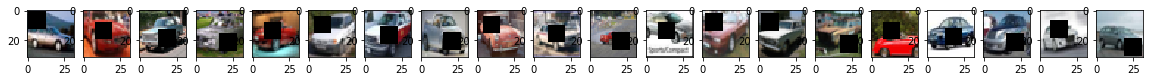

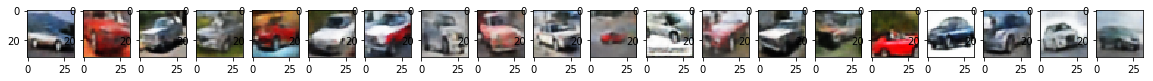

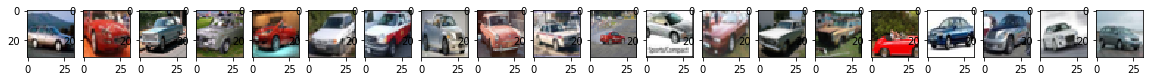

In [6]:
full_cvae_recons_train = full_cvae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,full_cvae_recons_train,20,10)
Plot_Img(20,x_tra,20,10)
plt.show()

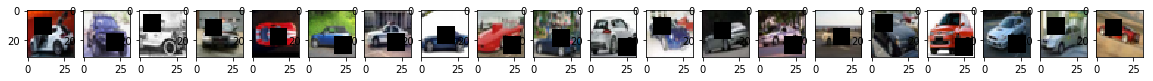

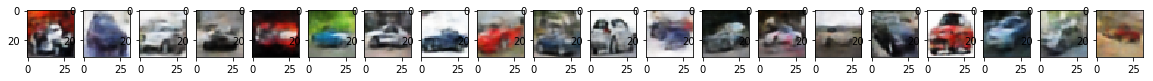

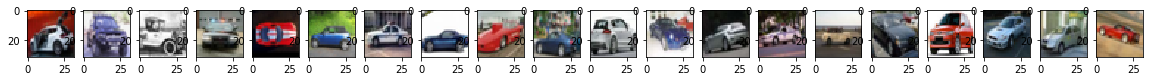

In [14]:
full_cvae_recons_test = full_cvae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,full_cvae_recons_test,20,10)
Plot_Img(20,x_te,20,10)
plt.show()

In [0]:
sqerror = []
for i in range(1000):
  sqerror.append(np.sum((full_cvae_recons_test[i]-x_te[i])**2))
sqerror = np.array(sqerror)

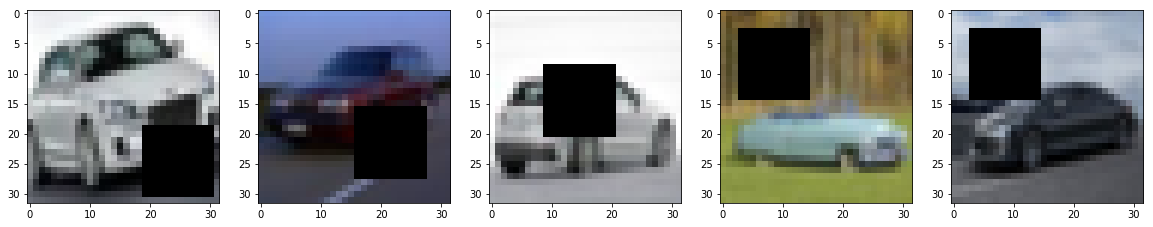

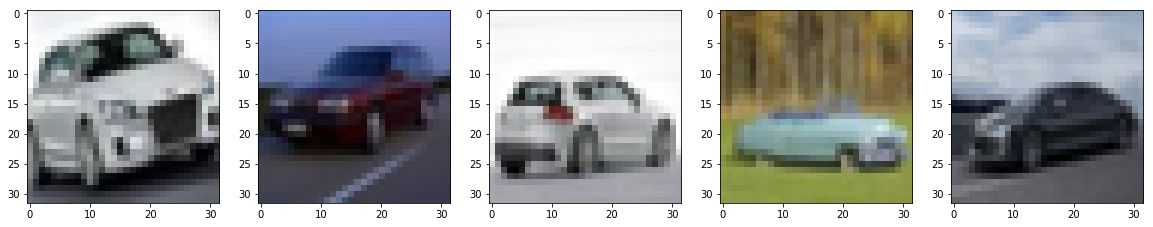

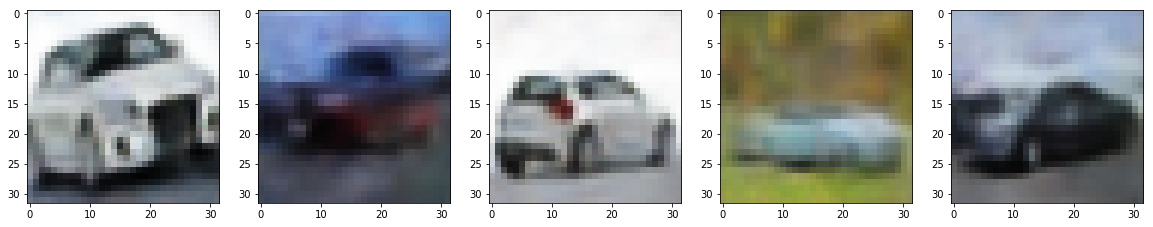

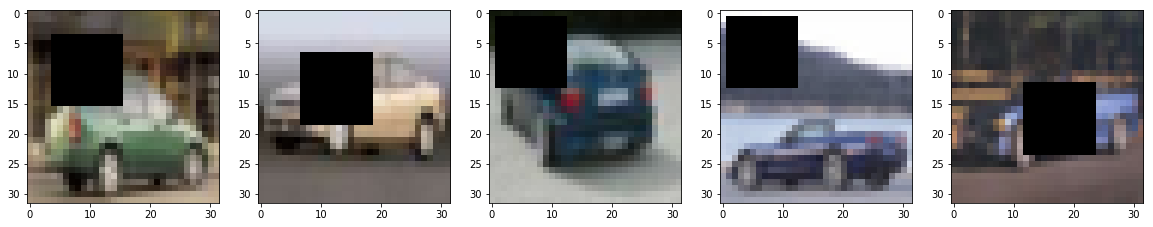

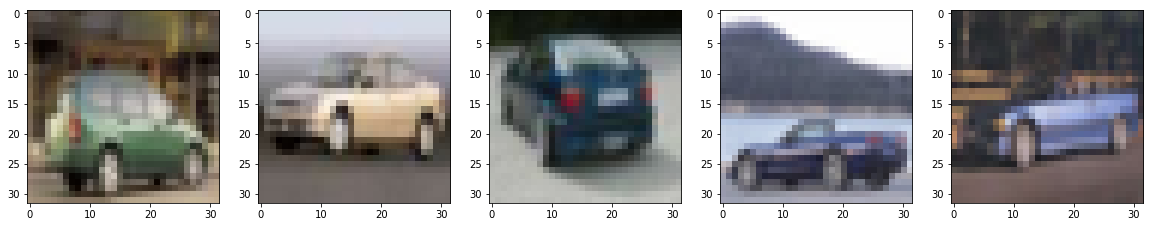

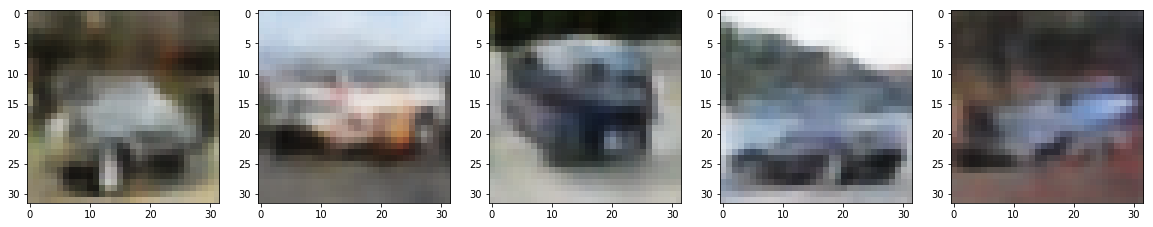

In [22]:
first_5 = np.argsort(sqerror)[10:15]
last_5 = np.argsort(sqerror)[200:205]

Plot_Img(5,x_test[first_5],20,10)
Plot_Img(5,x_te[first_5],20,10)
Plot_Img(5,full_cvae_recons_test[first_5],20,10)

Plot_Img(5,x_test[last_5],20,10)
Plot_Img(5,x_te[last_5],20,10)
Plot_Img(5,full_cvae_recons_test[last_5],20,10)

reconstruct the missing patches

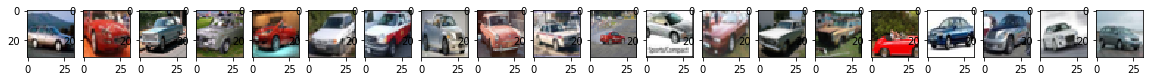

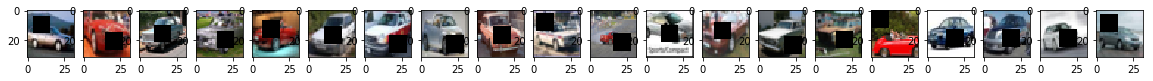

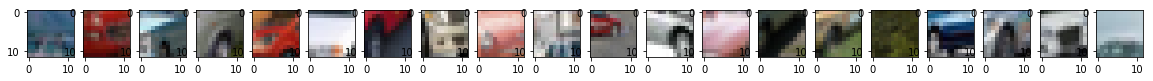

In [0]:
# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
Plot_Img(20,x_train_patches,20,10)
plt.show()

In [0]:
def csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.square(x-decode_z),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + cvae_log_var - K.square(cvae_mu) - K.exp(cvae_log_var), axis=-1)
    return xent_loss + kl_loss

In [0]:
# Construct the CVAE model
X = layers.Input(batch_shape=(batch_size,height,width,channels))
cond = layers.Input(batch_shape=(batch_size,height,width,1))
cvae_Input = layers.concatenate([X,cond], axis=-1)
cvae_l1 = layers.Conv2D(32,(3,3),activation='relu',strides=2,padding='same')(cvae_Input)
cvae_l1 = layers.BatchNormalization()(cvae_l1)
cvae_l2 = layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(cvae_l1)
cvae_l2 = layers.BatchNormalization()(cvae_l2)
cvae_l3 = layers.Conv2D(128,(3,3),activation='relu',strides=2,padding='same')(cvae_l2)
cvae_l3 = layers.BatchNormalization()(cvae_l3)
cvae_l4 = layers.Conv2D(256,(3,3),activation='relu',strides=2,padding='same')(cvae_l3)
flat_layer = layers.Flatten()(cvae_l4)
cvae_mu = layers.Dense(h_dim,activation='relu')(flat_layer)
cvae_log_var = layers.Dense(h_dim,activation='relu')(flat_layer)

# Imputed latent values
cvae_z = layers.Lambda(csampling, output_shape=(h_dim,))([cvae_mu, cvae_log_var])
cond2 = layers.Flatten()(cond)
cvae_z_cond = layers.concatenate([cvae_z,cond2], axis=-1)
cvae_z_cond = layers.Reshape((2,2,512))(cvae_z_cond)

# CVAE decoder layers
cvae_decoder_111 = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=2,padding='same')
cvae_decoder_l21 = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=2,padding='same')
cvae_decoder_l31 = layers.Conv2DTranspose(64,(3,3),activation='relu')
cvae_decoder_l41 = layers.Conv2DTranspose(64,(3,3),activation='relu')
cvae_decoder_l4 = layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')

# CVAE model
cvae_decoder_1 = cvae_decoder_111(cvae_z_cond)
cvae_decoder_2 = cvae_decoder_l21(cvae_decoder_1)
cvae_decoder_3 = cvae_decoder_l31(cvae_decoder_2)
cvae_decoder_4 = cvae_decoder_l41(cvae_decoder_3)
cvae_decoded = cvae_decoder_l4(cvae_decoder_4)
cvae = Model([X,cond],cvae_decoded)
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (50, 32, 32, 4)      0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (50, 16, 16, 32)     1184        concatenate_3[0][0]              
__________

In [0]:
cvae_opt = optimizers.Adam(0.0005,0.5)
cvae.compile(optimizer=cvae_opt, loss=cvae_loss)
cvae.fit([x_train,cond_train],x_train_patches,epochs=1000,batch_size=batch_size)

Epoch 1/1000
5000/5000 [==============================] - 3s 509us/step - loss: 1371.2768
Epoch 2/1000
5000/5000 [==============================] - 1s 255us/step - loss: 1080.2477
Epoch 3/1000
5000/5000 [==============================] - 1s 256us/step - loss: 953.6704
Epoch 4/1000
5000/5000 [==============================] - 1s 254us/step - loss: 900.4267
Epoch 5/1000
5000/5000 [==============================] - 1s 255us/step - loss: 863.1633
Epoch 6/1000
5000/5000 [==============================] - 1s 258us/step - loss: 827.3193
Epoch 7/1000
5000/5000 [==============================] - 1s 260us/step - loss: 806.3016
Epoch 8/1000
5000/5000 [==============================] - 1s 258us/step - loss: 778.6940
Epoch 9/1000
5000/5000 [==============================] - 1s 256us/step - loss: 759.6680
Epoch 10/1000
5000/5000 [==============================] - 1s 265us/step - loss: 737.8989
Epoch 11/1000
5000/5000 [==============================] - 1s 266us/step - loss: 721.1252
Epoch 12/1000
500

In [0]:
cvae.save('/content/drive/My Drive/cvae_1000.h5')

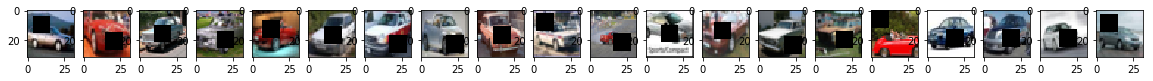

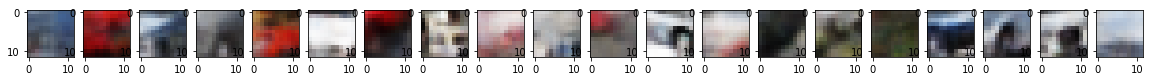

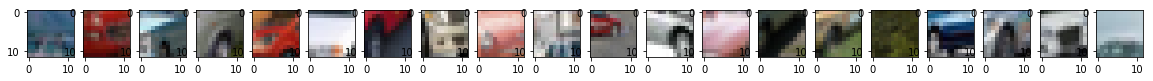

In [0]:
cvae_recons_train = cvae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,cvae_recons_train,20,10)
Plot_Img(20,x_train_patches,20,10)
plt.show()

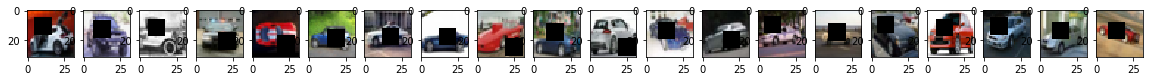

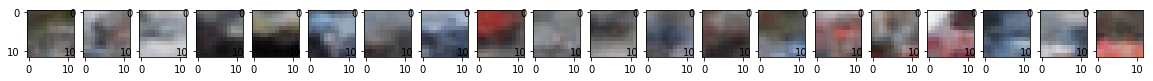

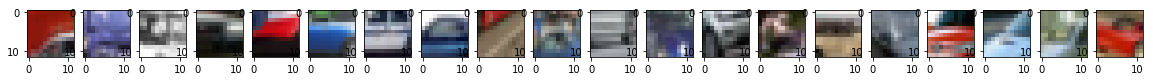

In [0]:
cvae_recons_test = cvae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,cvae_recons_test,20,10)
Plot_Img(20,x_test_patches,20,10)
plt.show()